# Section 2

## Chapter 4 - Encoding, Transforming, and Scaling Features

#### Scaling

Models often perform better with scaling so that features with higher variability do not overwhelm the optimization.

#### Data Leakage

Data leakage occurs whenever our models are informed by data that is not in the training dataset. Sometimes, we inadvertently assist our model training with information that cannot be gleaned from the training data alone. 

example: have missing values and then impute the mean across the dataset. Subsequently split our data into training and test set. Would have accidentally introduced data leakage. 

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
import feature_engine.selection as fesel
from IPython.core.interactiveshell import InteractiveShell
from category_encoders.hashing import HashingEncoder
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine import transformation as vt
from scipy import stats
from feature_engine.discretisation import EqualFrequencyDiscretiser as efd
from feature_engine.discretisation import EqualWidthDiscretiser as ewd
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [2]:
nls97 = pd.read_csv(r'/Users/dalebraganzamenezes/Desktop/Machine Learning Data Cleaning/nls97b.csv')
nls97.set_index('personid', inplace=True)

### Creating Training and Testing Datasets

test_size = 0.3. 

30% of the observations are used for testing.

In [3]:
feature_cols = ['satverbal','satmath','gpascience','gpaenglish','gpamath','gpaoverall']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(nls97[feature_cols], nls97[['wageincome']], test_size = 0.3, random_state = 0)

In [5]:
# Check that 30% of observations are in the test set as expected
# Have a look at the dataframes created for the testing and training
(X_test.shape[0] / nls97.shape[0])
X_train.info()
y_train.info()
X_test.info()
y_test.info()

0.30008904719501334

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6288 entries, 574974 to 370933
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   satverbal   1001 non-null   float64
 1   satmath     1001 non-null   float64
 2   gpascience  3998 non-null   float64
 3   gpaenglish  4078 non-null   float64
 4   gpamath     4056 non-null   float64
 5   gpaoverall  4223 non-null   float64
dtypes: float64(6)
memory usage: 343.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6288 entries, 574974 to 370933
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   wageincome  3599 non-null   float64
dtypes: float64(1)
memory usage: 98.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2696 entries, 363170 to 629736
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   satverbal   405 non-null    float64
 1  

### Removing Redundant or Unhelpful Features

Example 1: 
There might be features that are so highly correlated that it is very unlikely that we could build a model that could use all of them effectively.

Example 2:
Perhaps we subsetted data based on a single feature value, and we have retained that feature even though it now has the same value for all observations. 

Example 3
Or, for the subset of the data that we are using, two features have the same value.

In [6]:
ltpoland = pd.read_csv(r'/Users/dalebraganzamenezes/Desktop/Machine Learning Data Cleaning/ltpoland.csv')
ltpoland.set_index('station',inplace=True)

,satverbal,satmath,gpascience,gpaenglish,gpamath,gpaoverall
satverbal,1.000000,0.728890,0.438588,0.443692,0.375226,0.420707
satmath,0.728890,1.000000,0.479757,0.430359,0.517770,0.484701
gpascience,0.438588,0.479757,1.000000,0.671744,0.606340,0.792695
gpaenglish,0.443692,0.430359,0.671744,1.000000,0.599713,0.843816
gpamath,0.375226,0.517770,0.606340,0.599713,1.000000,0.750494
gpaoverall,0.420707,0.484701,0.792695,0.843816,0.750494,1.000000


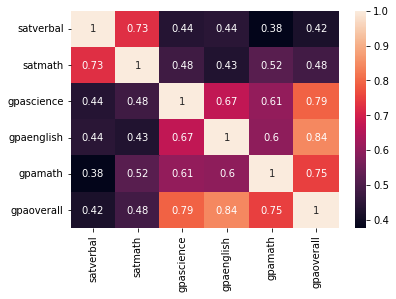

In [7]:
# See how the features are correlated
X_train.corr()
sns.heatmap(X_train.corr(), annot=True)

The corr method returns the Pearson coefficients by default. This is fine when we can assume a linear relationship between the features. However, when this assumption does not make sense, we should consider requesting Spearman coefficients instead. We can do that by passing spearman to the method parameter of corr.
 

We pass 0.75 to the threshold parameter of DropCorrelatedFeatures, indicating that we want to use Pearson coefficients and that we want to evaluate all the features by setting the variables to None.

In [8]:
tr = fesel.DropCorrelatedFeatures(method='pearson', threshold=0.75)

In [9]:
tr.fit(X_train)
X_train_tr = tr.transform(X_train)
X_test_tr = tr.transform(X_test)

DropCorrelatedFeatures(threshold=0.75)

In [10]:
X_train_tr.info()
X_test_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6288 entries, 574974 to 370933
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   satverbal   1001 non-null   float64
 1   satmath     1001 non-null   float64
 2   gpascience  3998 non-null   float64
 3   gpaenglish  4078 non-null   float64
 4   gpamath     4056 non-null   float64
dtypes: float64(5)
memory usage: 294.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2696 entries, 363170 to 629736
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   satverbal   405 non-null    float64
 1   satmath     406 non-null    float64
 2   gpascience  1686 non-null   float64
 3   gpaenglish  1720 non-null   float64
 4   gpamath     1710 non-null   float64
dtypes: float64(5)
memory usage: 126.4 KB


Typically, we would evaluate a feature more carefully before deciding to drop it. However, there are times when feature selection is part of a pipeline, and we need to automate the process. This can be done with DropCorrelatedFeatures since all of the feature_engine methods can be brought into a scikit-learn pipeline.

In [11]:
# Training and Test Datasets for Poland dataset
# With random_state=0 , we get the same train and test sets across different executions.
feature_cols = ['year','month','latabs','latitude','elevation',
               'longitude','country']
X_train, X_test, y_train, y_test = train_test_split(ltpoland[feature_cols], 
                                                   ltpoland[['temperature']], test_size=0.3, random_state = 0)

In [12]:
X_train.sample(5, random_state = 88)
X_train['year'].value_counts()
X_train['country'].value_counts()
(X_train['latitude'] != X_train['latabs']).sum()

,year,month,latabs,latitude,elevation,longitude,country
station,,,,,,,
BALICE,2019,7,50.078,50.078,241.1,19.7850,Poland
LEBA,2019,1,54.750,54.750,2.0,17.5331,Poland
ELBLAG_MILEJEWO,2019,5,54.167,54.167,43.0,19.4330,Poland
WLODAWA,2019,2,51.550,51.550,179.0,23.5330,Poland
LEBA,2019,11,54.750,54.750,2.0,17.5331,Poland


2019    84
Name: year, dtype: int64

Poland    84
Name: country, dtype: int64

0

In [13]:
# Drop features with the same values throughout the training dataset
tr = fesel.DropConstantFeatures()
tr.fit(X_train)
X_train_tr = tr.transform(X_train)
X_test_tr = tr.transform(X_test)
X_train_tr.head()

DropConstantFeatures()

,month,latabs,latitude,elevation,longitude
station,,,,,
OKECIE,1,52.166,52.166,110.3,20.9670
LAWICA,8,52.421,52.421,93.9,16.8260
LEBA,11,54.750,54.750,2.0,17.5331
SIEDLCE,10,52.250,52.250,152.0,22.2500
BIALYSTOK,11,53.100,53.100,151.0,23.1670


In [14]:
# Drop features that have the same values as other features. Dropping
# latitude that has the same values as latabs. 

tr = fesel.DropDuplicateFeatures()
tr.fit(X_train_tr)
X_train_tr = tr.transform(X_train_tr)
X_train_tr.head()

DropDuplicateFeatures()

,month,latabs,elevation,longitude
station,,,,
OKECIE,1,52.166,110.3,20.9670
LAWICA,8,52.421,93.9,16.8260
LEBA,11,54.750,2.0,17.5331
SIEDLCE,10,52.250,152.0,22.2500
BIALYSTOK,11,53.100,151.0,23.1670


This fixes some obvious problems with our features in the NLS data and the land temperature data for Poland. We dropped gpaoverall from a DataFrame that has the other GPA features because it is highly correlated with them. Additionally, we removed redundant data, dropping features with the same value throughout the DataFrame and features that duplicate the values of another feature.

### Encoding Categorical Features

Reasons why we might need to encode features before using them in machine learning: 

1. Algorithms typically require numeric data. 


2. When a categorical feature is represented with numbers we need to encode the values so that they are recognized as categorical. For example 1 for Female and 2 for male. 


3. Third, the feature might actually be ordinal, with a discrete number of values that represent some meaningful ranking. Our models need to capture that ranking.


4. Finally, a categorical feature might have a large number of values (known as high cardinality), and we might want our encoding to collapse categories.

One-hot encoding a feature creates a binary vector for each value of that feature.

The transformed features, letter_A, letter_B, and letter_C, are often referred to as dummy variables.

Can handle the encoding of features with a limited number of values, say 15 or less, with one-hot encoding.

In [15]:
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [16]:
nls97 = pd.read_csv(r'/Users/dalebraganzamenezes/Desktop/Machine Learning Data Cleaning/nls97b.csv')
nls97.set_index('personid', inplace=True)

In [17]:
feature_cols = ['gender','maritalstatus','colenroct99']
nls97demo = nls97[['wageincome'] + feature_cols].dropna()

In [18]:
X_demo_train, X_demo_test, y_demo_train, y_demo_test = \
train_test_split(nls97demo[feature_cols], nls97demo[['wageincome']],
                test_size=0.3, random_state=0)

One option we have for the encoding is the pandas get_dummies method. We can use it to indicate that we want to convert the gender and maritalstatus features. get_dummies gives us a dummy variable for each value of gender and maritalstatus. For example, gender has the values of Female and Male. get_dummies creates a feature, gender_Female, which is 1 when gender is Female and 0 when gender is Male. When gender is Male, gender_Male is 1 and gender_Female is

In [19]:
pd.get_dummies(X_demo_train,columns=['gender','maritalstatus']).head(5).T

personid,736081,832734,453537,322059,324323
colenroct99,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,2. 2-year college
gender_Female,1,0,0,1,1
gender_Male,0,1,1,0,0
maritalstatus_Divorced,0,0,0,1,0
maritalstatus_Married,1,0,1,0,1
maritalstatus_Never-married,0,1,0,0,0
maritalstatus_Separated,0,0,0,0,0
maritalstatus_Widowed,0,0,0,0,0


Typically, we create k-1 dummy variables for k unique values for a feature. So, if gender has two values in our data, we only need to create one dummy variable.

If we know the value for gender_Female, we also know the value of gender_Male; therefore, the latter variable is redundant. Similarly, we know the value of maritalstatus_Divorced if we know the values of the other maritalstatus dummies. Creating a redundancy in this way is inelegantly referred to as the dummy variable trap. To avoid this problem, we drop one dummy from each group.

For some machine learning algorithms, such as linear regression, dropping one dummy variable is actually required. In estimating the parameters of a linear model, the matrix is inverted. If our model has an intercept, and all dummy variables are included, the matrix cannot be inverted.

In [20]:
pd.get_dummies(X_demo_train,columns=['gender','maritalstatus'],\
              drop_first=True).head(2).T

personid,736081,832734
colenroct99,1. Not enrolled,1. Not enrolled
gender_Male,0,1
maritalstatus_Married,1,0
maritalstatus_Never-married,0,1
maritalstatus_Separated,0,0
maritalstatus_Widowed,0,0


An alternative to get_dummies is the one-hot encoder in either sklearn or feature_engine. These one-hot encoders have the advantage that they can be easily brought into a machine learning pipeline, and they can persist information gathered from the training dataset to the testing dataset.

In [21]:
ohe = OneHotEncoder(drop_last=True, variables = ['gender','maritalstatus'])

In [22]:
ohe.fit(X_demo_train)
X_demo_train_ohe = ohe.transform(X_demo_train)
X_demo_test_ohe = ohe.transform(X_demo_test)
X_demo_train_ohe.head(2).T

OneHotEncoder(drop_last=True, variables=['gender', 'maritalstatus'])

personid,736081,832734
colenroct99,1. Not enrolled,1. Not enrolled
gender_Female,1,0
maritalstatus_Married,1,0
maritalstatus_Never-married,0,1
maritalstatus_Divorced,0,0
maritalstatus_Separated,0,0


### Ordinal Encoding

When a categorical feature is ordinal, we want the encoding to capture the ranking of the values. For example, if we have a feature that has the values of low, medium, and high, one-hot encoding would lose this ordering. Instead, a transformed feature with the values of 1, 2, and 3 for low, medium, and high, respectively, would be better. We can accomplish this with ordinal encoding.

In [23]:
X_demo_train['colenroct99'].unique()
X_demo_train.head()
# Pass array of the categorical values into the OrdinalEncoder 
oe = OrdinalEncoder(categories = [X_demo_train['colenroct99'].unique()])

array(['1. Not enrolled', '2. 2-year college ', '3. 4-year college'],
      dtype=object)

,gender,maritalstatus,colenroct99
personid,,,
736081,Female,Married,1. Not enrolled
832734,Male,Never-married,1. Not enrolled
453537,Male,Married,1. Not enrolled
322059,Female,Divorced,1. Not enrolled
324323,Female,Married,2. 2-year college


In [24]:
colenr_enc = pd.DataFrame(oe.fit_transform(X_demo_train[['colenroct99']]), \
                         columns = ['colenroct99'], index=X_demo_train.index)

In [25]:
X_demo_train_enc = X_demo_train[['gender','maritalstatus']].join(colenr_enc)

In [26]:
X_demo_train_enc.head()

,gender,maritalstatus,colenroct99
personid,,,
736081,Female,Married,0.0
832734,Male,Never-married,0.0
453537,Male,Married,0.0
322059,Female,Divorced,0.0
324323,Female,Married,1.0


In [27]:
# Do a comparison to check the numbers of the categorical values still match
X_demo_train['colenroct99'].value_counts().sort_index()
X_demo_train_enc['colenroct99'].value_counts().sort_index()

1. Not enrolled       3050
2. 2-year college      142
3. 4-year college      350
Name: colenroct99, dtype: int64

0.0    3050
1.0     142
2.0     350
Name: colenroct99, dtype: int64

Ordinal encoding is appropriate for non-linear models such as decision trees. It might not make sense in a linear regression model because that would assume that the distance between values was equally meaningful across the whole distribution. In this example, that would assume that the increase from 0 to 1 (that is, from no enrollment to 2-year enrollment) is the same thing as the increase from 1 to 2 (that is, from 2-year enrollment to 4-year enrollment).

One-hot encoding and ordinal encoding are relatively straightforward approaches to engineering categorical features. It can be more complicated to deal with categorical features when there are many more unique values.

### Encoding categorical features with medium or high cardinality

When we are working with a categorical feature that has many unique values, say 10 or more, it can be impractical to create a dummy variable for each value. When there is high cardinality, that is, a very large number of unique values, there might be too few observations with certain values to provide much information for our models. At the extreme, with an ID variable, there is just one observation for each value. 


There are a couple of ways in which to handle medium or high cardinality. One way is to create dummies for the top k categories and group the remaining values into an other category. Another way is to use feature hashing, also known as the hashing trick.

#### One Hot Encoding

In [28]:
covidtotals = pd.read_csv(r'/Users/dalebraganzamenezes/Desktop/Machine Learning Data Cleaning/covidtotals.csv')

In [29]:
# Picking out the feature variables
feature_cols = ['location','population','aged_65_older','diabetes_prevalence'\
               ,'region']

In [30]:
# Combining response column with feature columns and also dropping missing
# values
covidtotals = covidtotals[['total_cases'] + feature_cols].dropna()

In [31]:
# Splitting data into testing and training sets 
X_test, X_train, y_test, y_train = train_test_split(covidtotals[feature_cols], covidtotals[['total_cases']], 
                                                   test_size = 0.3, random_state = 0)

In [32]:
X_train['region'].value_counts()

Western Europe     7
West Asia          5
South America      5
West Africa        5
Eastern Europe     5
East Asia          4
Caribbean          4
Central America    4
Central Africa     4
Oceania / Aus      3
East Africa        3
South Asia         2
Southern Africa    2
North Africa       1
Central Asia       1
Name: region, dtype: int64

In [33]:
# Using one hot encoder 

We can use the OneHotEncoder module from feature_engine again to encode the region feature. This time, we use the top_categories parameter to indicate that we only want to create dummies for the top six category values. Any values that do not fall into the top 6 categories have 0 for the dummies. 

In [34]:
ohe = OneHotEncoder(top_categories = 6, variables = ['region'])

# Applying one hot encoder to the dataframe to create a new dataframe
# with the covidtotals
covidtotals_ohe = ohe.fit_transform(covidtotals)

In [35]:
covidtotals_ohe.filter(regex = 'location|region', axis = 'columns').sample(5, random_state = 99).T

,97,173,92,187,104
location,Israel,Senegal,Indonesia,Sri Lanka,Kenya
region_Eastern Europe,0,0,0,0,0
region_Western Europe,0,0,0,0,0
region_West Africa,0,1,0,0,0
region_East Asia,0,0,1,0,0
region_West Asia,1,0,0,0,0
region_East Africa,0,0,0,0,1


#### Feature Hashing

Feature hashing maps a large number of unique feature values to a smaller number of dummy variables. We can specify the number of dummy variables to create. However, collisions are possible; that is, some feature values might map to the same dummy variable combination. The number of collisions increases as we decrease the number of requested dummy variables.

In [36]:
X_train['region2'] = X_train['region']
he = HashingEncoder(cols=['region'], n_components=6)
X_train_enc = he.fit_transform(X_train)

In [37]:
X_train_enc.groupby(['col_0','col_1','col_2','col_3','col_4','col_5','region2']).size().reset_index()

,col_0,col_1,col_2,col_3,col_4,col_5,region2,0
0,0,0,0,0,0,1,Caribbean,4
1,0,0,0,0,0,1,Central Africa,4
2,0,0,0,0,0,1,East Africa,3
3,0,0,0,0,0,1,North Africa,1
4,0,0,0,0,1,0,Central America,4
5,0,0,0,0,1,0,Eastern Europe,5
6,0,0,0,0,1,0,Oceania / Aus,3
7,0,0,0,0,1,0,Southern Africa,2
8,0,0,0,0,1,0,West Asia,5
9,0,0,0,0,1,0,Western Europe,7


### Using Mathematical Transformations

Sometimes, we want to use features that do not have a Gaussian distribution with a machine learning algorithm that assumes our features are distributed in that way. 


When that happens, we either need to change our minds about which algorithm to use (for example, we could choose KNN rather than linear regression) or transform our features so that they approximate a Gaussian distribution.

In [38]:
covidtotals = pd.read_csv(r'/Users/dalebraganzamenezes/Desktop/Machine Learning Data Cleaning/covidtotals.csv')
feature_cols = ['location','population','aged_65_older','diabetes_prevalence','region']
covidtotals = covidtotals[['total_cases']+feature_cols].dropna()
X_train, X_test, y_train, y_test = train_test_split(covidtotals[feature_cols], covidtotals[['total_cases']], test_size = 0.3, random_state = 0)

In [39]:
# Getting the skew of the response variable 
y_train['total_cases'].skew()

6.313169268923333

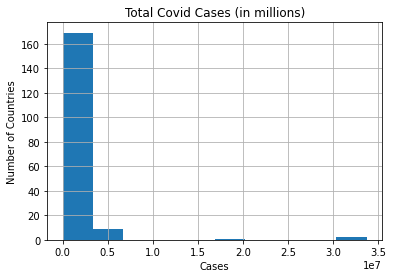

In [40]:
# Looking at the distribution of total cases
covidtotals.hist('total_cases')
plt.title('Total Covid Cases (in millions)')
plt.xlabel('Cases')
plt.ylabel('Number of Countries');

This illustrates the very high skew for the total number of cases. In fact, it looks log-normal, which is not surprising given the large number of very low values and several very high values.

#### Performing a Log Transformation

-1.387272802414152

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc20dc73550>]],
      dtype=object)

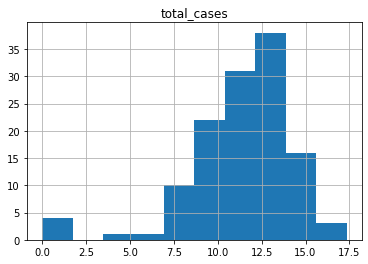

In [41]:
tf = vt.LogTransformer(variables = ['total_cases'])
y_train_tf = tf.fit_transform(y_train)
y_train_tf['total_cases'].skew()
y_train_tf.hist('total_cases')

Effectively, log transformations increase variability at the lower end of the distribution and decrease variability at the upper end. This produces a more symmetrical distribution. This is because the slope of the logarithmic function is steeper for smaller values than for larger ones.

#### Performing a Box-Cox Transformation

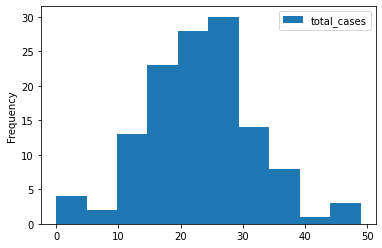

In [42]:
tf = vt.BoxCoxTransformer(variables = ['total_cases'])
y_train_tf = tf.fit_transform(y_train)
y_train_tf.skew()
y_train_tf.plot(kind='hist');

Box-Cox transformations identify a value for lambda between -5 and 5 that generates a distribution that is closest to normal. It uses the following equation for the transformation

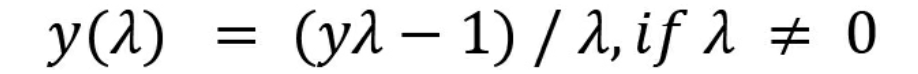

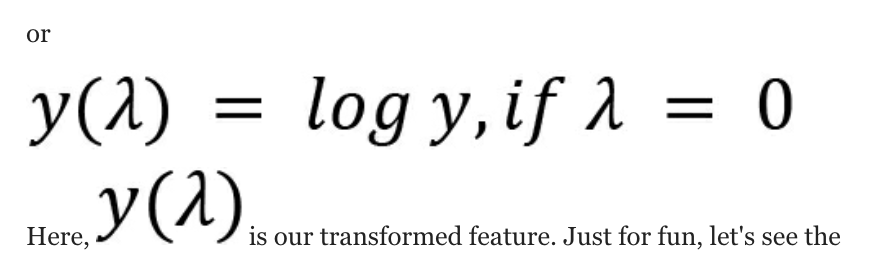

In [43]:
# Checking the figure of lambda used for the box cox transformation
stats.boxcox(y_train['total_cases'])[1]

0.10435377585681517

The lambda for a feature with a Gaussian distribution would be 1.000, meaning that no transformation would be necessary.

Now that our transformed total cases feature looks good, we can build a model with it as the target. Additionally, we can set up our pipeline to restore values to their original scaling when we make predictions. feature_engine has a number of other transformations that are implemented similarly to the log and Box-Cox transformations.

## Feature Binning

Sometimes, we will want to convert a continuous feature into a categorical feature. The process of creating k equally spaced intervals from the minimum to the maximum value of a distribution is called binning or, the somewhat less-friendly term, discretization. Binning can address several important issues with a feature: skew, excessive kurtosis, and the presence of outliers.

### Equal-Width and Equal-Frequency Binning

In [44]:
covidtotals = pd.read_csv(r'/Users/dalebraganzamenezes/Desktop/Machine Learning Data Cleaning/covidtotals.csv')

In [45]:
feature_cols = ['location','population','aged_65_older','diabetes_prevalence','region']

In [46]:
covidtotals[['total_cases']+feature_cols].dropna()

,total_cases,location,population,aged_65_older,diabetes_prevalence,region
0,129021.0,Afghanistan,38928341.0,2.581,9.59,South Asia
1,132557.0,Albania,2877800.0,13.188,10.08,Eastern Europe
2,143032.0,Algeria,43851043.0,6.211,6.73,North Africa
4,39491.0,Angola,32866268.0,2.405,3.94,Central Africa
6,1265.0,Antigua and Barbuda,97928.0,6.933,13.17,Caribbean
...,...,...,...,...,...,...
215,280980.0,Venezuela,28435943.0,6.614,6.47,South America
216,23385.0,Vietnam,97338583.0,7.150,6.00,East Asia
218,6934.0,Yemen,29825968.0,2.922,5.35,West Asia
219,169003.0,Zambia,18383956.0,2.480,3.94,Southern Africa


In [47]:
x_train, X_test, y_train, y_test = train_test_split(covidtotals[feature_cols], covidtotals[['total_cases']], random_state = 0, test_size=0.3)

In [48]:
y_train.dropna(inplace=True)
y_test.dropna(inplace=True)

In [49]:
# Use pandas cut and qcut method to create bins of equal frequency
y_train['total_cases_group'] = pd.qcut(y_train['total_cases'], q=10, labels = [0,1,2,3,4,5,6,7,8,9,])

In [50]:
y_train['total_cases_group'].value_counts().sort_index()

0    14
1    14
2    13
3    14
4    14
5    13
6    14
7    13
8    14
9    14
Name: total_cases_group, dtype: int64

In [51]:
# Can also use the EqualFrequencyDiscretiser to achieve the same thing 
def runtransform(bt, dftrain, dftest):
    bt.fit(dftrain)
    train_bins = bt.transform(dftrain)
    test_bins = bt.transform(dftest)
    return train_bins, test_bins

In [52]:
y_train.drop(['total_cases_group'], axis = 1, inplace=True)
bintransformer = efd(q=10, variables = ['total_cases'])

In [53]:
y_train_bins, y_test_bins = runtransform(bintransformer, y_train, y_test)

In [54]:
y_train_bins['total_cases'].value_counts().sort_index()

0    14
1    14
2    13
3    14
4    14
5    13
6    14
7    13
8    14
9    14
Name: total_cases, dtype: int64

This gives us the same results as qcut, but it has the advantage of being easier to bring into a machine learning pipeline since we are using feature_engine to produce it. The equal-frequency binning addresses both the skew and outlier problems.

In [55]:
bintransformer = ewd(bins=10, variables = ['total_cases'])
y_train_bins, y_test_bins = runtransform(bintransformer, y_train, y_test)
y_train_bins['total_cases'].value_counts().sort_index()

0    129
1      5
5      1
9      2
Name: total_cases, dtype: int64

This is a far less successful transformation. Almost all of the values are at the bottom of the distribution in the data prior to the binning, so it is not surprising that equal-width binning would have the same problem. It results in only 4 bins, even though we requested 10.

Let's examine the range of each bin. Here, we can see that the equal-width binner is not even able to construct equal-width bins because of the small number of observations at the top of the distribution:

In [56]:
pd.options.display.float_format = '{:,.0f}'.format
y_train_bins = y_train_bins.rename(columns = {'total_cases':'total_cases_group'}).join(y_train)
y_train_bins.groupby('total_cases_group')['total_cases'].agg(['min','max'])

,min,max
total_cases_group,,
0,2,"3,304,135"
1,"4,265,714","5,856,682"
5,"18,909,037","18,909,037"
9,"30,709,557","33,770,444"


Although in this case, equal-width binning was a bad choice, there are many times when it makes sense. It can be useful when data is more uniformly distributed or when the equal widths make sense substantively.

### K-Means Binning

Another option is to use k-means clustering to determine the bins. The k-means algorithm randomly selects k data points as centers of clusters and then assigns the other data points to the closest cluster. The mean of each cluster is computed, and the data points are reassigned to the nearest new cluster. This process is repeated until the optimal centers are found.

In [57]:
kbins = KBinsDiscretizer(n_bins=10, encode = 'ordinal', strategy='kmeans')

In [58]:
y_train_bins = pd.DataFrame(kbins.fit_transform(y_train), columns = ['total_cases'])

In [59]:
y_train_bins['total_cases'].value_counts().sort_index()

0    58
1    23
2    24
3    13
4     6
5     5
6     5
7     1
8     1
9     1
Name: total_cases, dtype: int64

In [60]:
y_train['total_cases'].agg(['skew','kurtosis'])

skew        6
kurtosis   44
Name: total_cases, dtype: float64

Binning can help us to address skew, kurtosis, and outliers in our data. However, it does mask much of the variation in the feature and reduces its explanatory potential. Often, some form of scaling, such as min-max or z-score, is a better option. Let's examine feature scaling next.

## Feature Scaling

Often, the features we want to use in our model are on very different scales. 


Put simply, the distance between the minimum and maximum values, or the range, varies substantially across possible features. 


For example, in the COVID-19 data, the total cases feature goes from 1 to almost 34 million, while aged 65 or older goes from 9 to 27 (the number represents the percentage of the population).

Having features on very different scales impacts many machine learning algorithms. 

For example, KNN models often use Euclidean distance, and features with greater ranges will have a greater influence on the model. 

Scaling can address this problem.

### Min-Max Scaling

Min-max scaling replaces each value with its location in the range.

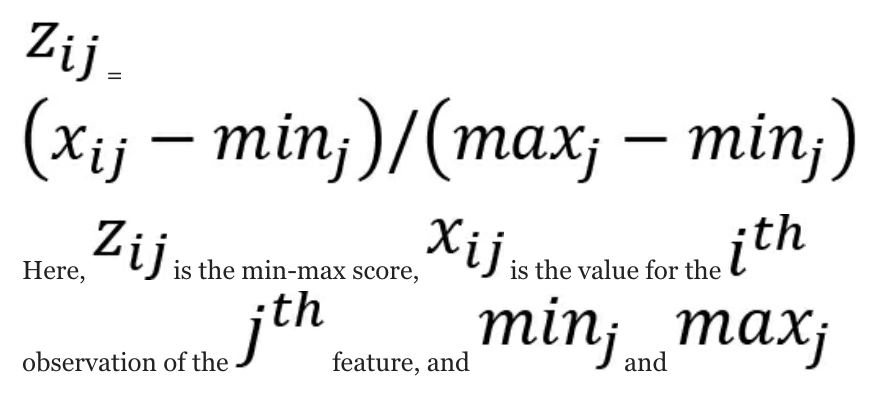

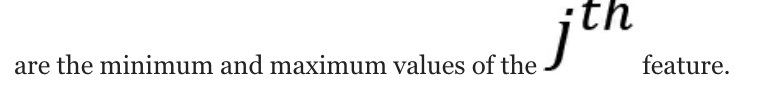

m = (x -xmin) / (xmax -xmin)

### Standard Scaling

Standard scaling normalizes the feature values around a mean of 0.

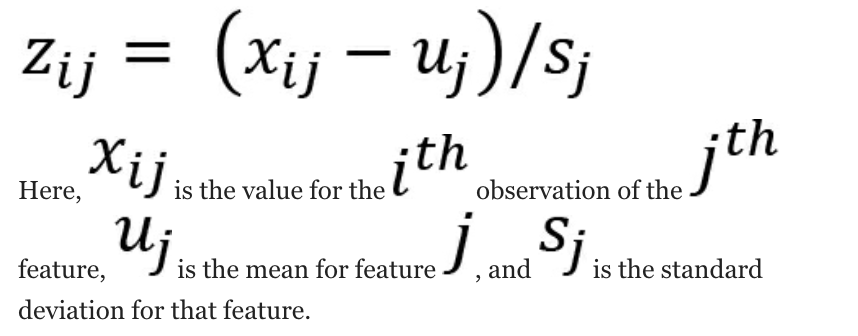

### Robust Scaling

If we have outliers in our data, robust scaling might be a good option. Robust scaling subtracts the median from each value of a variable and divides that value by the interquartile range.

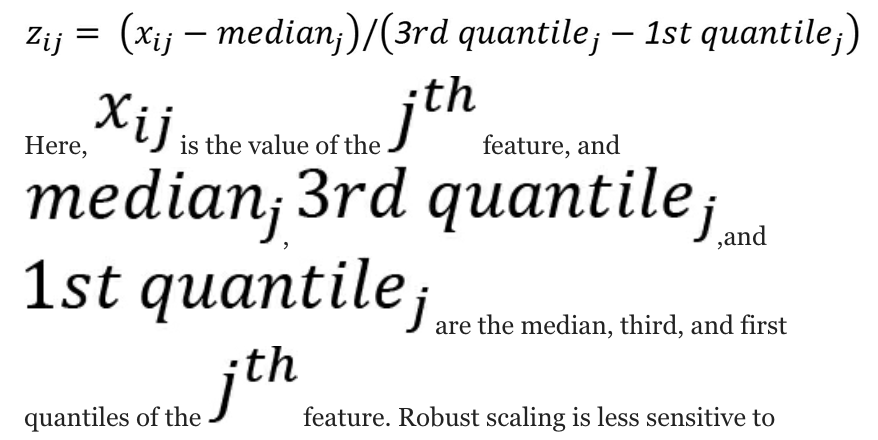

Robust scaling is less senstive to extreme values since it does not use mean or variance. 

In [88]:
covidtotals = pd.read_csv(r'/Users/dalebraganzamenezes/Desktop/Machine Learning Data Cleaning/covidtotals.csv')
feature_cols = ['population','total_deaths','aged_65_older','diabetes_prevalence']
covidtotals = covidtotals[['total_cases']+feature_cols].dropna()
X_train, X_test, y_train, y_test = train_test_split(covidtotals[feature_cols], covidtotals[['total_cases']], test_size = 0.3, random_state = 2, )

In [98]:
# Applying Min-Max Scaler
scaler = MinMaxScaler()
X_train_mms = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_train_mms
X_train_mms.describe()
pd.options.display.float_format = '{:,.3f}'.format

,population,total_deaths,aged_65_older,diabetes_prevalence
121,0.02,0.01,0.20,0.75
161,0.00,0.00,0.01,0.74
196,0.05,0.00,0.39,0.29
69,0.00,0.00,0.78,0.23
87,0.01,0.01,0.14,0.30
...,...,...,...,...
52,0.01,0.05,0.69,0.28
27,0.15,0.87,0.29,0.34
88,0.01,0.00,0.59,0.35
18,0.01,0.04,0.67,0.16


,population,total_deaths,aged_65_older,diabetes_prevalence
count,123.00,123.00,123.00,123.00
mean,0.03,0.04,0.28,0.33
std,0.13,0.14,0.24,0.20
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.08,0.18
50%,0.01,0.00,0.19,0.29
75%,0.02,0.01,0.48,0.43
max,1.00,1.00,1.00,1.00


In [99]:
# Applying Standard Scaler 
scaler = StandardScaler()
X_train_ss = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index=X_train.index)
X_train_ss.describe()

,population,total_deaths,aged_65_older,diabetes_prevalence
count,123.000,123.000,123.000,123.000
mean,-0.000,0.000,-0.000,0.000
std,1.004,1.004,1.004,1.004
min,-0.274,-0.283,-1.164,-1.670
25%,-0.259,-0.281,-0.834,-0.735
50%,-0.225,-0.262,-0.387,-0.193
75%,-0.126,-0.194,0.824,0.524
max,7.624,6.919,2.987,3.406


In [105]:
# Applying Robust Scaler
scaler = RobustScaler()
X_train_rs = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index=X_train.index)
X_train_rs.describe()

,population,total_deaths,aged_65_older,diabetes_prevalence
count,123.00,123.00,123.00,123.00
mean,1.69,3.01,0.23,0.15
std,7.55,11.55,0.61,0.80
min,-0.37,-0.25,-0.47,-1.17
25%,-0.26,-0.22,-0.27,-0.43
50%,0.00,0.00,0.00,0.00
75%,0.74,0.78,0.73,0.57
max,59.02,82.59,2.03,2.86


We use feature scaling with most machine learning algorithms. Although it is not often required, it yields noticeably better results. 


Min-max scaling and standard scaling are popular scaling techniques, but there are times when robust scaling might be the better option.

### Summary

1. Dropped redundant and highly correlated features. 


2. We explored the most common kinds of encoding – one-hot encoding, ordinal encoding, and hashing encoding.


> We almost always need to encode our features for algorithms in order to understand them correctly. For example, most algorithms cannot make sense of female or male values or know not to treat ZIP codes as ordinal.


3. Used transformations to improve the distribution of our features. 

> When we are using algorithms that assume a Gaussian distribution of our features, some form of transformation might be required for our features to be consistent with that assumption. 

4. Used common binning and scaling approaches to address skew, kurtosis and outliers. 


5. Adjust for features with widely different ranges. 

> Although not typically necessary, scaling is often a very good idea when we have features with vastly different ranges. 